<a href="https://colab.research.google.com/github/theSquaredError/NLP-projects/blob/main/classifying%20names%20with%20a%20character%20level%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

Problem: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Deep Learning/Notebooks"

A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [ ]:
def findFiles(path): return glob.glob(path)
print(findFiles(path+'/data/names/*.txt'))

['/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Polish.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Czech.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Spanish.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Arabic.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/English.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/German.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Greek.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Russian.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Korean.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Irish.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Portuguese.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Dutch.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Italian.txt', '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/

In [ ]:
findFiles(os.path.join(path,'data/names/*.txt'))

['/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Polish.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Czech.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Spanish.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Arabic.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/English.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/German.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Greek.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Russian.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Korean.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Irish.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Portuguese.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Dutch.txt',
 '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Italian.txt',
 '/content/drive/MyDrive/Deep Learning/Notebook

In [ ]:
import unicodedata
import string

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [ ]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles(path+'/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

In [ ]:
file_temp = '/content/drive/MyDrive/Deep Learning/Notebooks/data/names/Polish.txt'

In [ ]:
n_categories = len(all_categories)

In [ ]:
all_categories

['Polish',
 'Czech',
 'Spanish',
 'Arabic',
 'English',
 'German',
 'Greek',
 'Russian',
 'Korean',
 'Irish',
 'Portuguese',
 'Dutch',
 'Italian',
 'French',
 'Chinese',
 'Japanese',
 'Scottish',
 'Vietnamese']

In [ ]:
print(category_lines['Chinese'][:5])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


# Turning names to Tensor

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
  return all_letters.find(letter)

# Just for demonestration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# Turn a line into <line_length x 1 x n_letters> Tensor
# or an array of one-hot letter vectors

def lineToTensor(line):
  tensor = torch.zeros(len(line),1,n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

In [ ]:
print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Creating the network

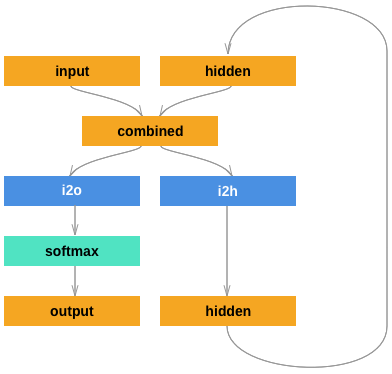

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size+hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input,hidden),1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)



In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
output

tensor([[-2.9129, -2.9209, -2.9433, -2.8332, -2.9372, -2.9441, -2.9925, -2.8702,
         -2.7732, -2.8915, -2.8092, -2.9973, -2.9541, -2.8613, -2.8680, -2.7891,
         -2.9078, -2.8571]], grad_fn=<LogSoftmaxBackward0>)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9129, -2.9209, -2.9433, -2.8332, -2.9372, -2.9441, -2.9925, -2.8702,
         -2.7732, -2.8915, -2.8092, -2.9973, -2.9541, -2.8613, -2.8680, -2.7891,
         -2.9078, -2.8571]], grad_fn=<LogSoftmaxBackward0>)


# Training

Preparing for the training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 8)


We will also want a quick way to get a training example (a name and its language):

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Pletcher
category = Greek / line = Malihoudis
category = Czech / line = Metjeka
category = Portuguese / line = Santiago
category = Russian / line = Babaevsky
category = English / line = Fitchett
category = Portuguese / line = Magalhaes
category = Italian / line = Vestri
category = Russian / line = Hudoleev
category = Irish / line = Gallchobhar


# Training the network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
 - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.6297 Tahan / Chinese ✗ (Arabic)
10000 10% (0m 10s) 2.8036 Matos / Greek ✗ (Portuguese)
15000 15% (0m 16s) 1.4857 Backer / German ✓
20000 20% (0m 21s) 2.0668 Edgell / French ✗ (English)
25000 25% (0m 26s) 0.5656 Zanetti / Italian ✓
30000 30% (0m 31s) 1.0211 Zhi / Chinese ✓
35000 35% (0m 37s) 0.4210 Assaf / Arabic ✓
40000 40% (0m 42s) 1.1259 Luc / Chinese ✗ (Vietnamese)
45000 45% (0m 47s) 0.6332 Hwang / Korean ✓
50000 50% (0m 53s) 1.4774 Martell / Spanish ✓
55000 55% (0m 59s) 1.4518 She / Korean ✗ (Chinese)
60000 60% (1m 4s) 0.5599 Klimek / Polish ✓
65000 65% (1m 9s) 2.1914 Pokorny / English ✗ (Czech)
70000 70% (1m 15s) 1.7752 Yoshimatsu / Greek ✗ (Japanese)
75000 75% (1m 20s) 0.0382 Kedzierski / Polish ✓
80000 80% (1m 25s) 1.2684 Mackay / Scottish ✓
85000 85% (1m 31s) 3.1271 Baudin / Irish ✗ (French)
90000 90% (1m 36s) 0.0917 Truong / Vietnamese ✓
95000 95% (1m 41s) 1.3053 Matos / Greek ✗ (Portuguese)
100000 100% (1m 47s) 0.9087 Roach / Irish ✓


# Evaluating the result

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop

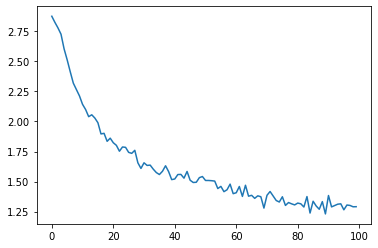

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

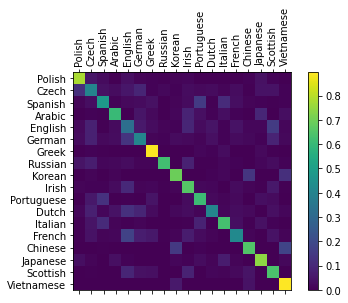

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.82) Czech
(-0.95) Russian
(-2.19) English

> Jackson
(-0.17) Scottish
(-2.29) English
(-4.15) Czech

> Satoshi
(-0.91) Japanese
(-1.44) Arabic
(-2.13) Italian
